In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchinfo

# Imports

In [50]:
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.transforms as transforms
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import sys
import os
import pandas as pd
from collections import Counter
import seaborn as sn
from sklearn.metrics import confusion_matrix
import torchvision
import numpy as np
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm
import cv2
import math
import glob
from PIL import Image

import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset, random_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# imports para as CNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

#sys.path.insert(1, '../../util') # Fernas
# sys.path.insert(1, '/content/drive/MyDrive/Mestrado/VCPI_Project/') # Cat
sys.path.insert(1, '/content/drive/MyDrive/VC/VCPI_Project/') # Martex
import vcpi_util

print(torch.__version__)

2.3.0+cu121


# Load data

In [51]:
# Definindo o dispositivo para treinamento
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Este é para o Fernas, quando vierem utilizar comentem
#DATASET_PATH = 'data'
#TEST_SET_PATH = DATASET_PATH + 'test_images'
#TRAIN_SET_PATH = DATASET_PATH + 'train_images/GTSRB/Final_Training/Images'

# DATASET_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/data' # Cat
DATASET_PATH = '/content/drive/MyDrive/VC/VCPI_Project/data' # Marta
TEST_SET_PATH = DATASET_PATH + '/test_images'
TRAIN_SET_PATH = DATASET_PATH + '/train_images/GTSRB/Final_Training/Images'

IMG_SIZE = 64
NUM_CHANNELS = 3 # Pictures are in RGB
BATCH_SIZE = 32
NUM_CLASSES = 43
CLASS_NAMES = os.listdir(f'{DATASET_PATH}/test_images')
EPOCHS = 20

cpu


# Converter imagens para .png

In [ ]:
from PIL import Image
import os

def convert_images_to_png(dataset_path, output_base_path):
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.ppm'):
                try:
                    img = Image.open(os.path.join(root, file), mode='r')
                    base_name = os.path.basename(root)
                    class_folder = os.path.join(output_base_path, base_name)

                    os.makedirs(class_folder, exist_ok=True)

                    new_path = os.path.join(class_folder, file.replace('.ppm', '.png'))
                    img.save(new_path)

                except Exception as e:
                    print(f"Erro ao converter {file}: {e}")

# Ensure these paths are correctly defined
# Cat
# PNG_TRAIN_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/train_png'
# PNG_TEST_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/test_png'

# Marta
PNG_TRAIN_PATH = '/content/drive/MyDrive/VC/VCPI_Project/train_png'
PNG_TEST_PATH = '/content/drive/MyDrive/VC/VCPI_Project/test_png'

# DATASET_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/data' # Cat
DATASET_PATH = '/content/drive/MyDrive/VC/VCPI_Project/data' # Marta
TRAIN_SET_PATH = DATASET_PATH + '/train_images/GTSRB/Final_Training/Images'
TEST_SET_PATH = DATASET_PATH + '/test_images'

# Definindo os caminhos relativos ao diretório atual de trabalho
BASE_DIR = os.path.abspath('.')
# PNG_TRAIN_PATH = os.path.join(BASE_DIR, 'train_png')
# PNG_TEST_PATH = os.path.join(BASE_DIR, 'test_png')

# DATASET_PATH = os.path.join(BASE_DIR, 'data')
# TRAIN_SET_PATH = os.path.join(DATASET_PATH, 'train_images', 'GTSRB', 'Final_Training', 'Images')
# TEST_SET_PATH = os.path.join(DATASET_PATH, 'test_images', 'GTSRB', 'Final_Test', 'Images')

# Imprima os caminhos para verificar se estão corretos
print("BASE_DIR:", BASE_DIR)
print("TRAIN_SET_PATH:", TRAIN_SET_PATH)
print("TEST_SET_PATH:", TEST_SET_PATH)
print("PNG_TRAIN_PATH:", PNG_TRAIN_PATH)
print("PNG_TEST_PATH:", PNG_TEST_PATH)

# Verifique se as pastas existem
assert os.path.exists(TRAIN_SET_PATH), f"Path does not exist: {TRAIN_SET_PATH}"
assert os.path.exists(TEST_SET_PATH), f"Path does not exist: {TEST_SET_PATH}"

# Converta as imagens antes de carregar o conjunto de dados
#convert_images_to_png(TRAIN_SET_PATH, PNG_TRAIN_PATH)
convert_images_to_png(TEST_SET_PATH, PNG_TEST_PATH)

BASE_DIR: /content
TRAIN_SET_PATH: /content/drive/MyDrive/VC/VCPI_Project/data/train_images/GTSRB/Final_Training/Images
TEST_SET_PATH: /content/drive/MyDrive/VC/VCPI_Project/data/test_images
PNG_TRAIN_PATH: /content/drive/MyDrive/VC/VCPI_Project/train_png
PNG_TEST_PATH: /content/drive/MyDrive/VC/VCPI_Project/test_png


In [52]:
# Cat
# PNG_TRAIN_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/train_png'
# PNG_TEST_PATH = '/content/drive/MyDrive/Mestrado/VCPI_Project/test_png'

# Marta
PNG_TRAIN_PATH = '/content/drive/MyDrive/VC/VCPI_Project/train_png'
PNG_TEST_PATH = '/content/drive/MyDrive/VC/VCPI_Project/test_png'

# Definição das transformações
transform = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),  # Redimensionar as imagens
    v2.ToTensor(),        # Converter as imagens para tensores
])


# data_gen = ImageDataGenerator(rescale=1./255)
# Carregamento dos conjuntos de treinamento e teste
train_loader = tf.keras.utils.image_dataset_from_directory(directory=PNG_TRAIN_PATH, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=True, label_mode='categorical', follow_links=True)
test_loader = tf.keras.utils.image_dataset_from_directory(directory=PNG_TEST_PATH, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical')

Found 33911 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.


In [53]:
# For the training set
train_images, train_targets = next(iter(train_loader))
print("Training Set:")
print("Batch shape:", train_images.shape)
print(f"Targets: {train_targets}")
print("Training set batches:", train_loader.cardinality().numpy())

Training Set:
Batch shape: (32, 64, 64, 3)
Targets: [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Training set batches: 1060


In [54]:
# For the test set
test_images, test_targets = next(iter(test_loader))
test_images = test_images / 255.0
print("\nTest Set:")
print("Batch shape:", test_images.shape)
img_np = test_images.numpy()
print("Each image varies between", np.min(img_np), "and", np.max(img_np))
# Putting color channel last so that the image can be displayed
test_images = np.transpose(img_np, (0, 2, 3, 1))
print("Shape after channel transpose:", img_np.shape)
print("Test set batches:", test_loader.cardinality().numpy())


Test Set:
Batch shape: (32, 64, 64, 3)
Each image varies between 0.0030326096 and 1.0
Shape after channel transpose: (32, 64, 3, 64)
Test set batches: 395


train_images: (32, 64, 64, 3)
test_images: (32, 64, 3, 64)


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

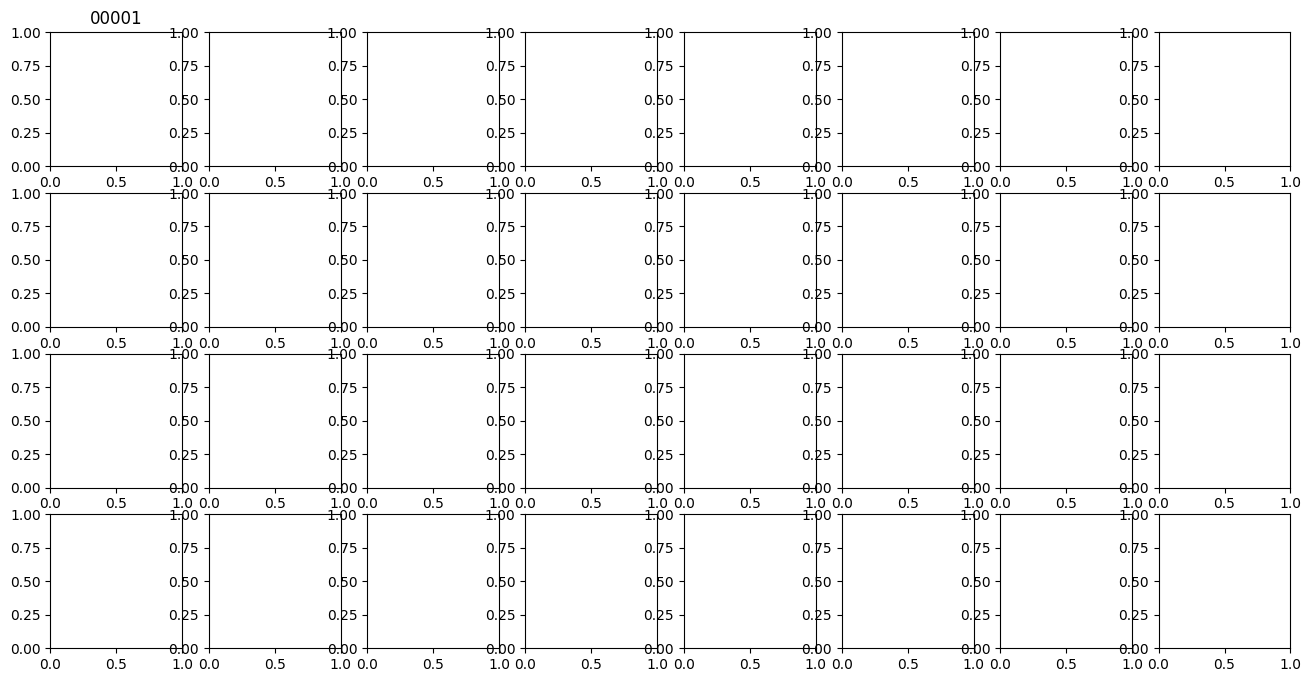

<Figure size 640x480 with 0 Axes>

In [59]:
# Convert train and test targets to integer labels
train_labels = np.array([np.argmax(target) for target in train_targets.numpy()])
test_labels = np.array([np.argmax(target) for target in test_targets.numpy()])

# Transpose the color channel to the last position
train_images = np.transpose(train_images, (0, 2, 3, 1))
test_images = np.transpose(test_images, (0, 2, 3, 1))

print(f'train_images: {train_images.shape}')
print(f'test_images: {test_images.shape}')

# Now pass the integer labels instead of the one-hot encoded targets to the show_images function
vcpi_util.show_images(4, 8, train_images, train_labels, train_loader.class_names)

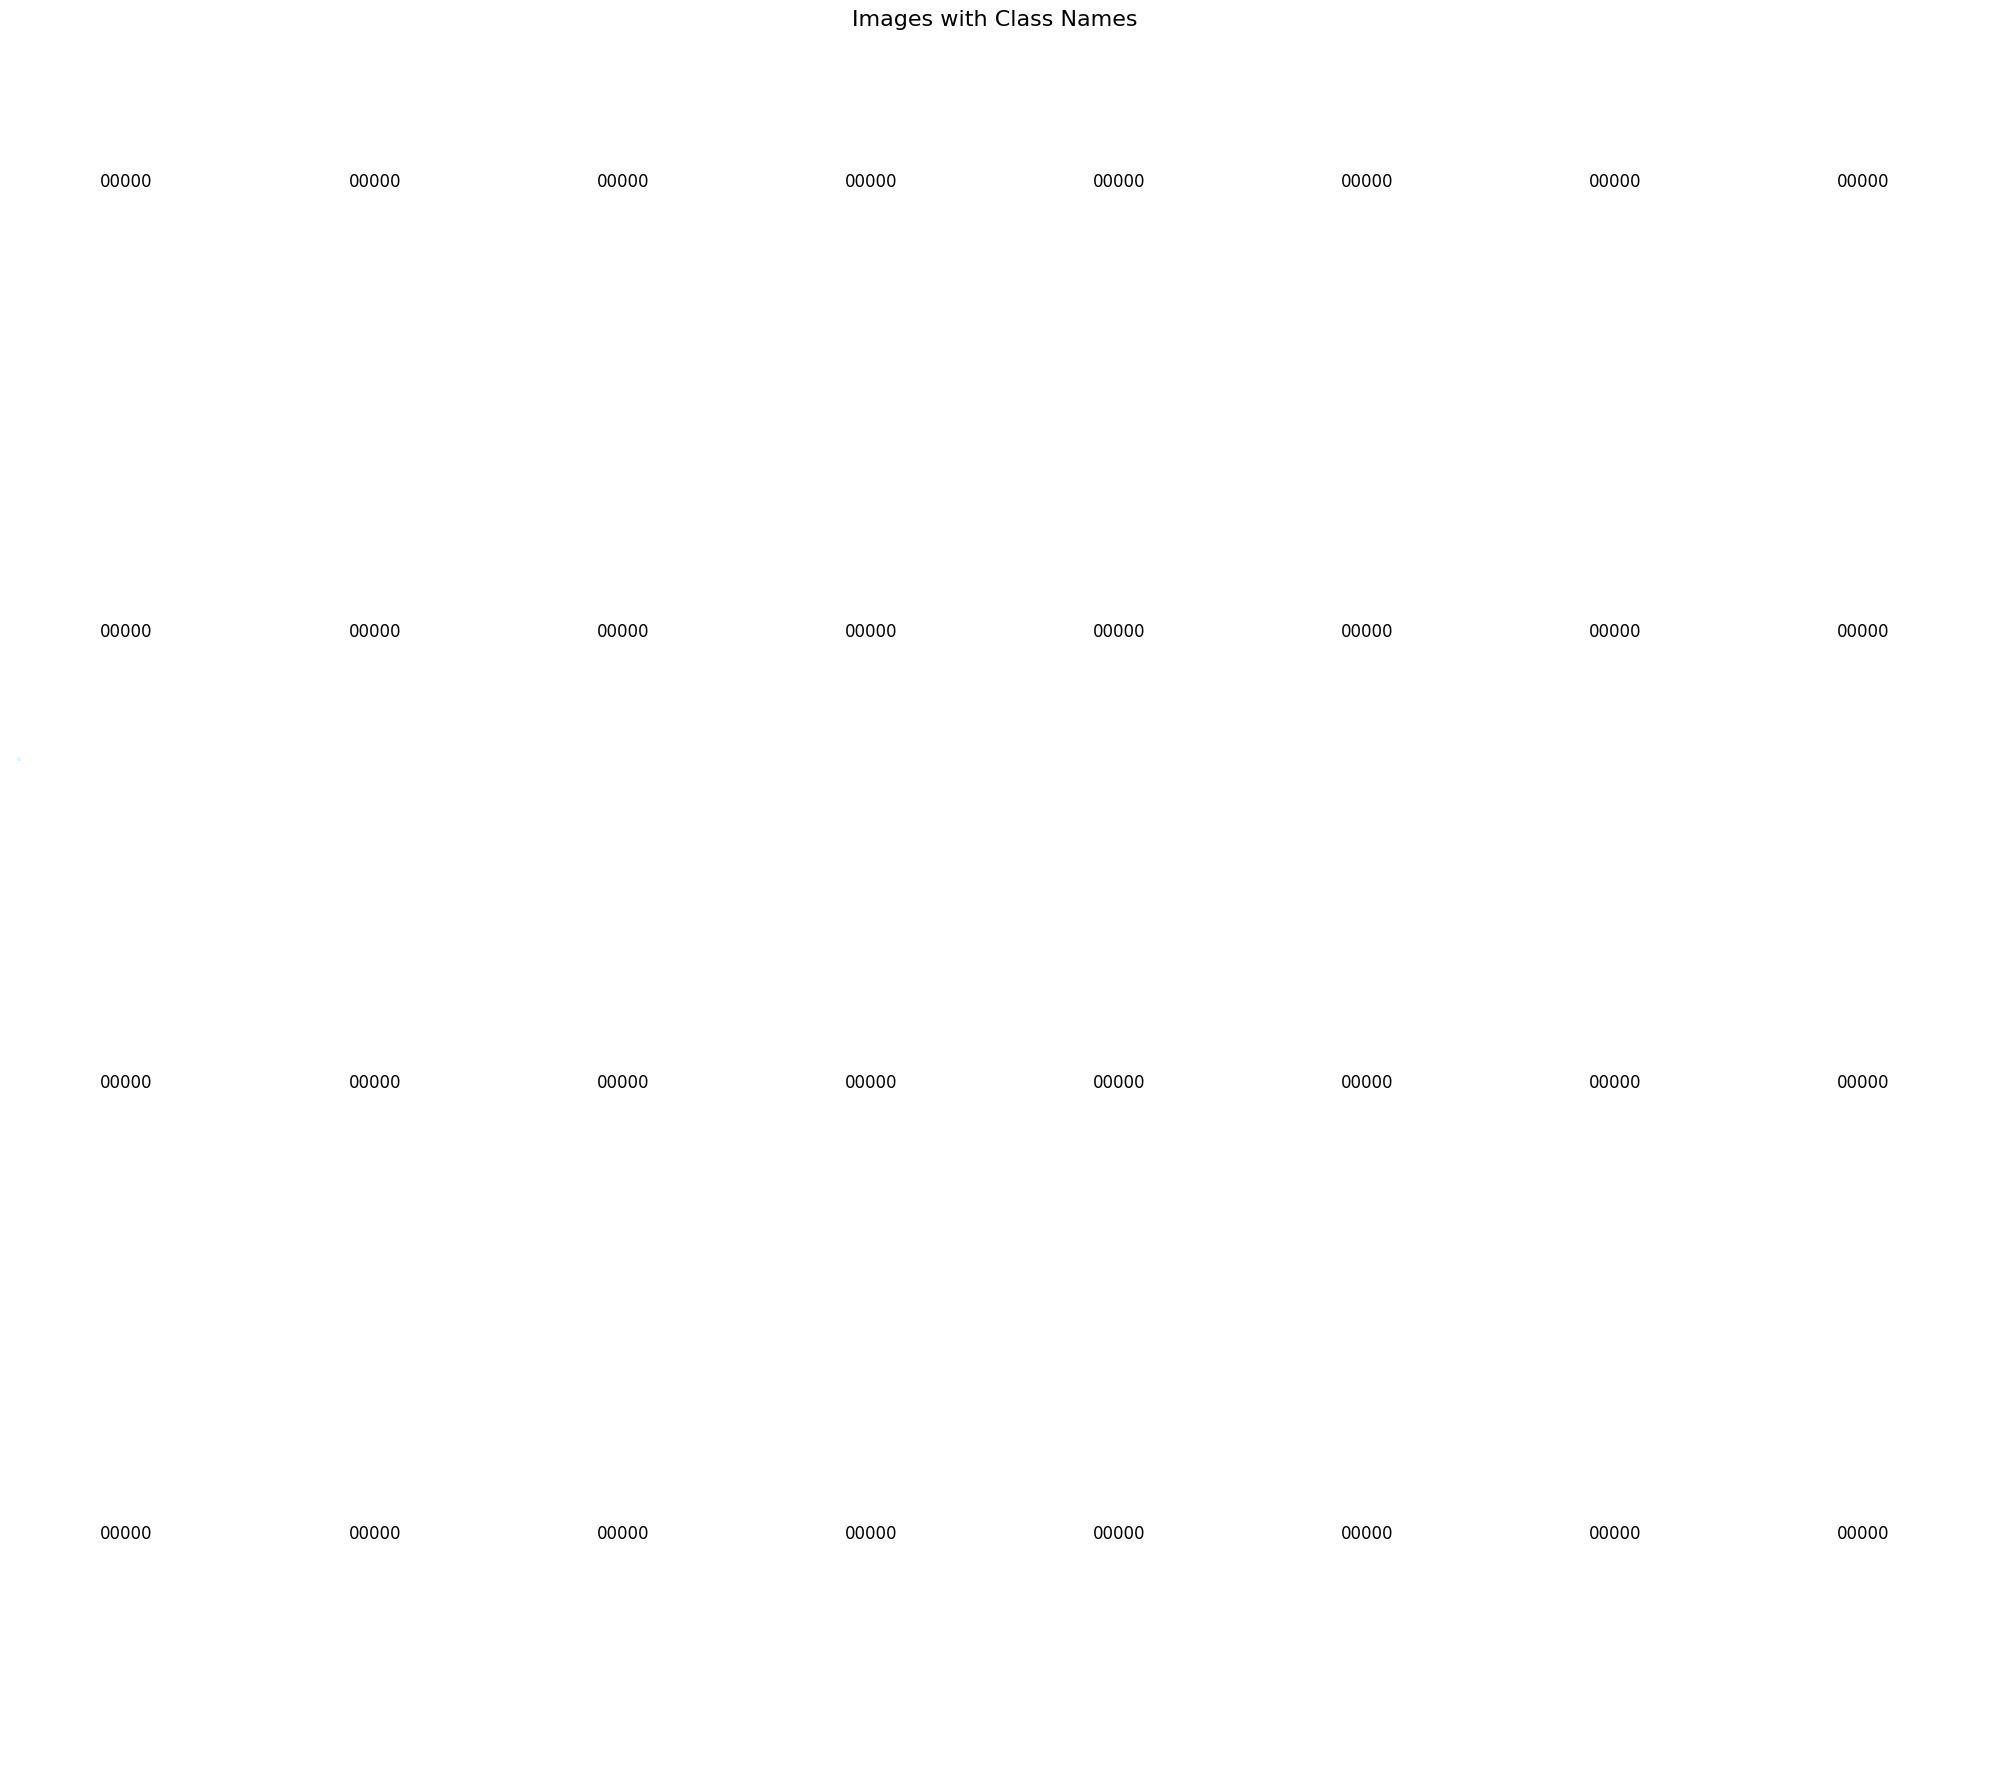

In [63]:
# Example function to display images in a 4x8 grid
def display_images_in_grid(images, labels, class_names, num_rows=4, num_cols=8):
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    fig.suptitle('Images with Class Names', fontsize=16)

    for i, ax in enumerate(axs.flat):
        # Extract image and label for the current subplot
        img = images[i]
        label = labels[i]

        # Convert one-hot encoded label to class name
        class_name = class_names[np.argmax(label)]

        # Display the image
        ax.imshow(img)
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming train_images, train_labels, and class_names are defined
display_images_in_grid(train_images, train_labels, train_loader.class_names, num_rows=4, num_cols=8)

IndexError: invalid index to scalar variable.

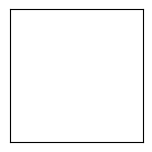

In [ ]:
plt.figure(figsize=(10,10))
for i in range(len(train_images)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(train_loader.class_names[train_labels[i][0]])
plt.show()

# Filtros e métodos de processamento de imagem


In [ ]:
# csv_directory = '/content/drive/MyDrive/Mestrado/VCPI_Project/data/train_images/GTSRB/Final_Training/Images' # Cat
csv_directory = '/content/drive/MyDrive/VC/VCPI_Project/data/train_images/GTSRB/Final_Training/Images' # Marta

# csv_directory = os.path.join(DATASET_PATH, 'train_images', 'GTSRB', 'Final_Training', 'Images')

image_info_by_class = {}

for subdir in os.listdir(csv_directory):
    subdir_path = os.path.join(csv_directory, subdir)
    if os.path.isdir(subdir_path):
        for filename in os.listdir(subdir_path):
            if filename.endswith('.csv'):
                csv_path = os.path.join(subdir_path, filename)

                if os.path.getsize(csv_path) == 0:
                    print(f'O arquivo CSV {csv_path} está vazio.')
                    continue

                with open(csv_path, 'r') as csvfile:
                    next(csvfile)  # Ignorar a primeira linha de cabeçalho
                    for line in csvfile:
                        row = line.strip().split(';')

                        if len(row) < 8:
                            print(f'A linha do arquivo CSV {csv_path} não possui informações suficientes.')
                            continue

                        image_filename = row[0]
                        class_id = row[7]

                        image_info = {
                            'Filename': row[0],
                            'Width': row[1],
                            'Height': row[2],
                            'Roi.X1': row[3],
                            'Roi.Y1': row[4],
                            'Roi.X2': row[5],
                            'Roi.Y2': row[6],
                            'ClassId': row[7]
                        }

                        class_dict_key = f'GT-{class_id.zfill(5)}'
                        if class_dict_key not in image_info_by_class:
                            image_info_by_class[class_dict_key] = {}
                        image_info_by_class[class_dict_key][image_filename] = image_info


In [ ]:
 # Exemplo de como acessar as informações de uma imagem específica de uma classe específica
class_id = '00042'
image_filename = '00000_00000.ppm'
class_dict_key = f'GT-{class_id.zfill(5)}'
image_info = image_info_by_class.get(class_dict_key, {}).get(image_filename)
if image_info:
  print(f'Informações da imagem {image_filename} da classe {class_id}: {image_info}')
else:
  print(f'As informações da imagem {image_filename} da classe {class_id} não foram encontradas.')

Informações da imagem 00000_00000.ppm da classe 00042: {'Filename': '00000_00000.ppm', 'Width': '27', 'Height': '28', 'Roi.X1': '5', 'Roi.Y1': '6', 'Roi.X2': '22', 'Roi.Y2': '23', 'ClassId': '42'}


# Display batch of images

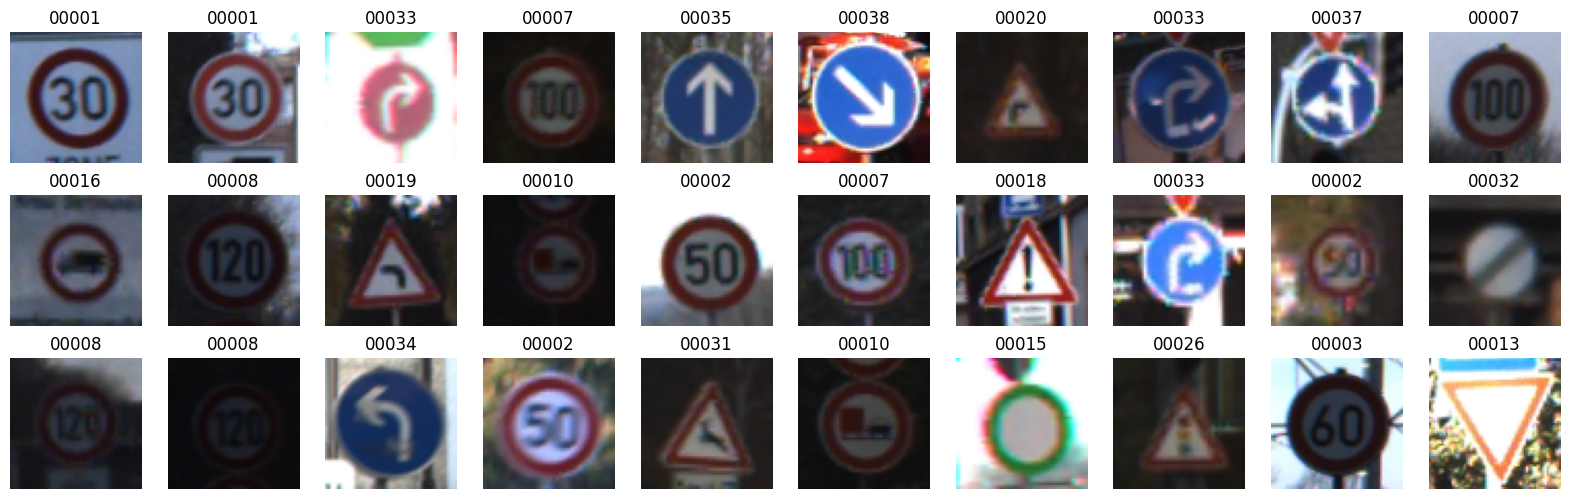

<Figure size 640x480 with 0 Axes>

In [ ]:
vcpi_util.show_images(3,10, train_images, train_targets, train_set.classes)

Counter({1: 3, 33: 3, 7: 3, 8: 3, 2: 3, 10: 2, 13: 2, 35: 1, 38: 1, 20: 1, 37: 1, 16: 1, 19: 1, 18: 1, 32: 1, 34: 1, 31: 1, 15: 1, 26: 1, 3: 1})


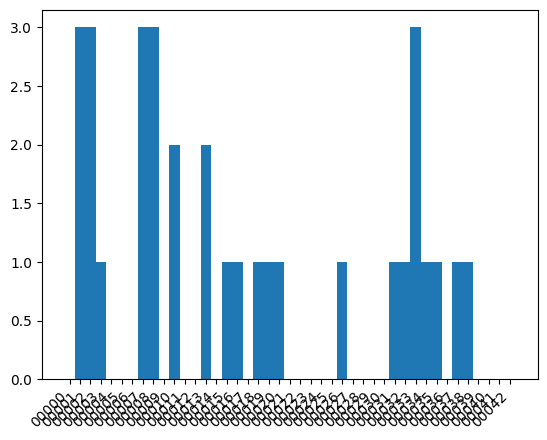

In [ ]:
vcpi_util.show_histogram(train_targets, train_set.classes)

In [ ]:
# Função para mostrar o histograma de uma imagem
def show_image_histogram(image, ax, image_name):
    ax.hist(image.flatten(), bins=50, color='c')
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')
    ax.set_title(image_name)

In [ ]:
# Verificar normalização dos valores das imagens [0.0, 1.0]
print("Valor mínimo train_images:", torch.min(train_images))
print("Valor máximo train_images:", torch.max(train_images))
print()
print("Valor mínimo test_images:", torch.min(test_images))
print("Valor máximo test_images:", torch.max(test_images))

Valor mínimo train_images: tensor(0.0039)
Valor máximo train_images: tensor(1.)

Valor mínimo test_images: tensor(0.)
Valor máximo test_images: tensor(1.)


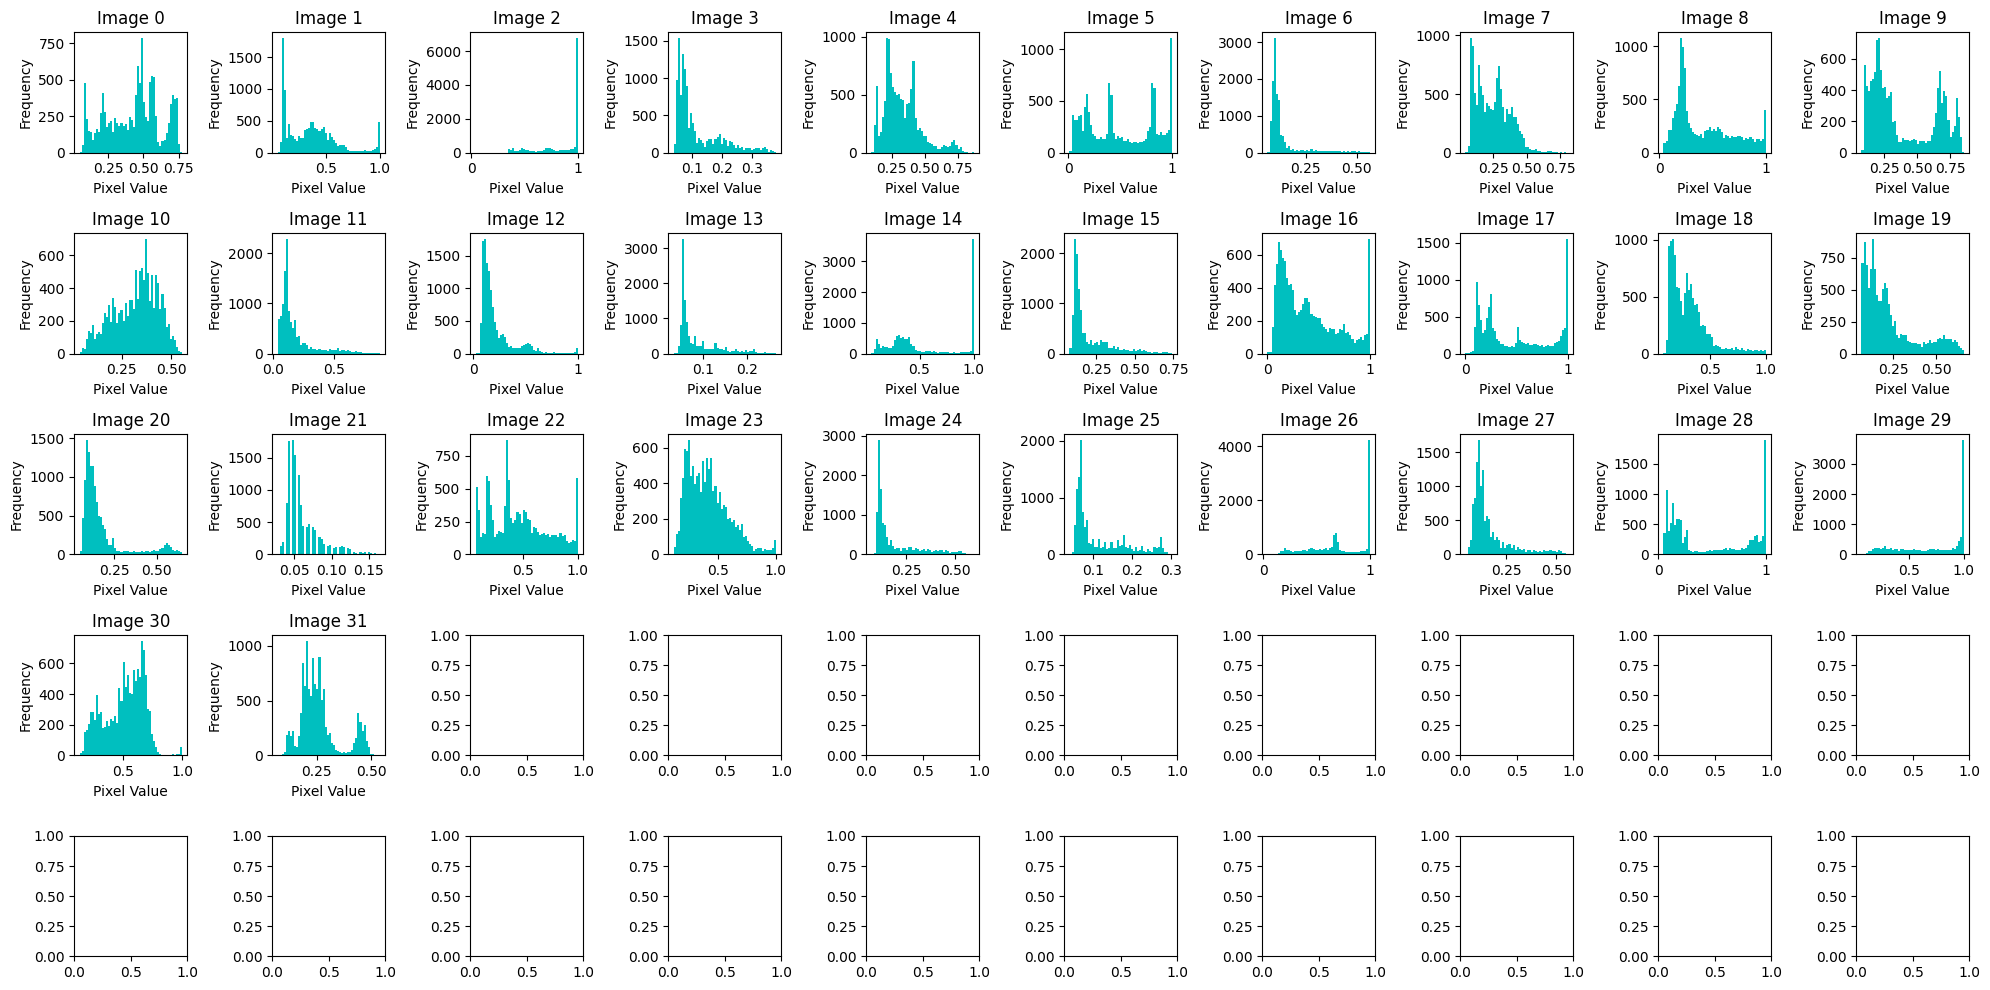

In [ ]:
rows = 5
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

imagesHist, _ = train_images, train_targets
for i, image in enumerate(imagesHist):
    # Calcular as coordenadas da subplot
    row = i // cols
    col = i % cols
    # Mostrar o histograma da imagem atual na subplot correspondente
    show_image_histogram(image, axes[row, col], f'Image {i}')
    # Parar o loop quando atingirmos o número total de subplots
    if i == rows * cols - 1:
      break

plt.tight_layout()
plt.show()

Equalização do histograma de frequências

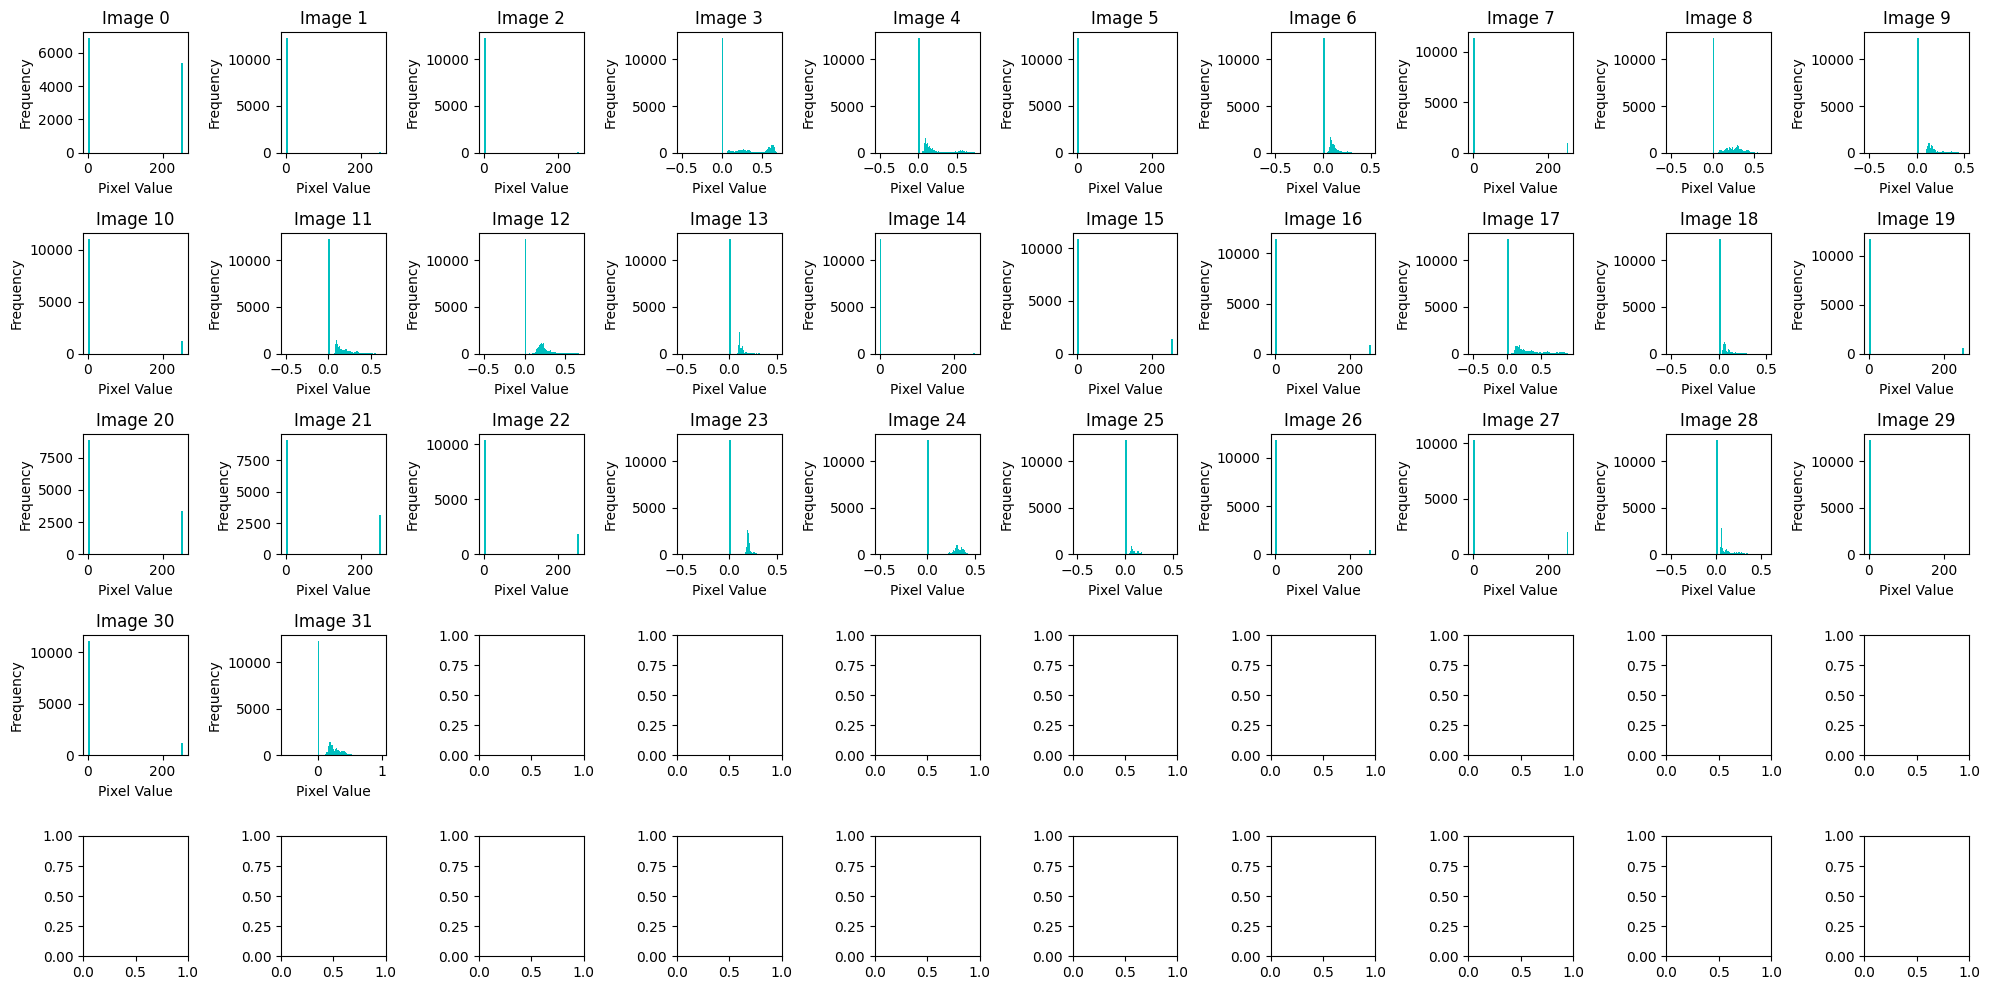

In [ ]:
# Função para equalizar o histograma de uma imagem usando OpenCV
def equalize_image_histogram_cv2(image):
    # Assuming the image is a stack of grayscale images
    # Convert each channel to a grayscale image and equalize its histogram
    equalized_channels = []
    for channel in range(image.shape[0]):
        channel_image = image[channel, :, :]
        channel_image = channel_image.astype('uint8')
        equalized_channel = cv2.equalizeHist(channel_image)
        equalized_channels.append(equalized_channel)

    # Combine the equalized channels back into a single image
    equalized_image = np.stack(equalized_channels, axis=0)
    return equalized_image

rows = 5
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

imagesHist, _ = train_images, train_targets
equalized_imgs = []
for i, image in enumerate(imagesHist):
    # Calcular as coordenadas da subplot
    row = i // cols
    col = i % cols
    # Equalizar o histograma da imagem atual usando OpenCV
    equalized_image_cv2 = equalize_image_histogram_cv2(image.numpy())
    equalized_imgs.append(equalized_image_cv2)
    # Mostrar o histograma da imagem equalizada na subplot correspondente
    show_image_histogram(equalized_image_cv2, axes[row, col], f'Image {i}')
    # Parar o loop quando atingirmos o número total de subplots
    if i == rows * cols - 1:
        break

for i, image in enumerate(imagesHist):
    # Calcular as coordenadas da subplot
    row = i // cols
    col = i % cols
    if isinstance(image, torch.Tensor):
        image_np = image.numpy()
    else:
        image_np = image
    show_image_histogram(image_np, axes[row, col], f'Image {i}')
    # Parar o loop quando atingirmos o número total de subplots
    if i == rows * cols - 1:
        break

plt.tight_layout()
plt.show()

Filtros

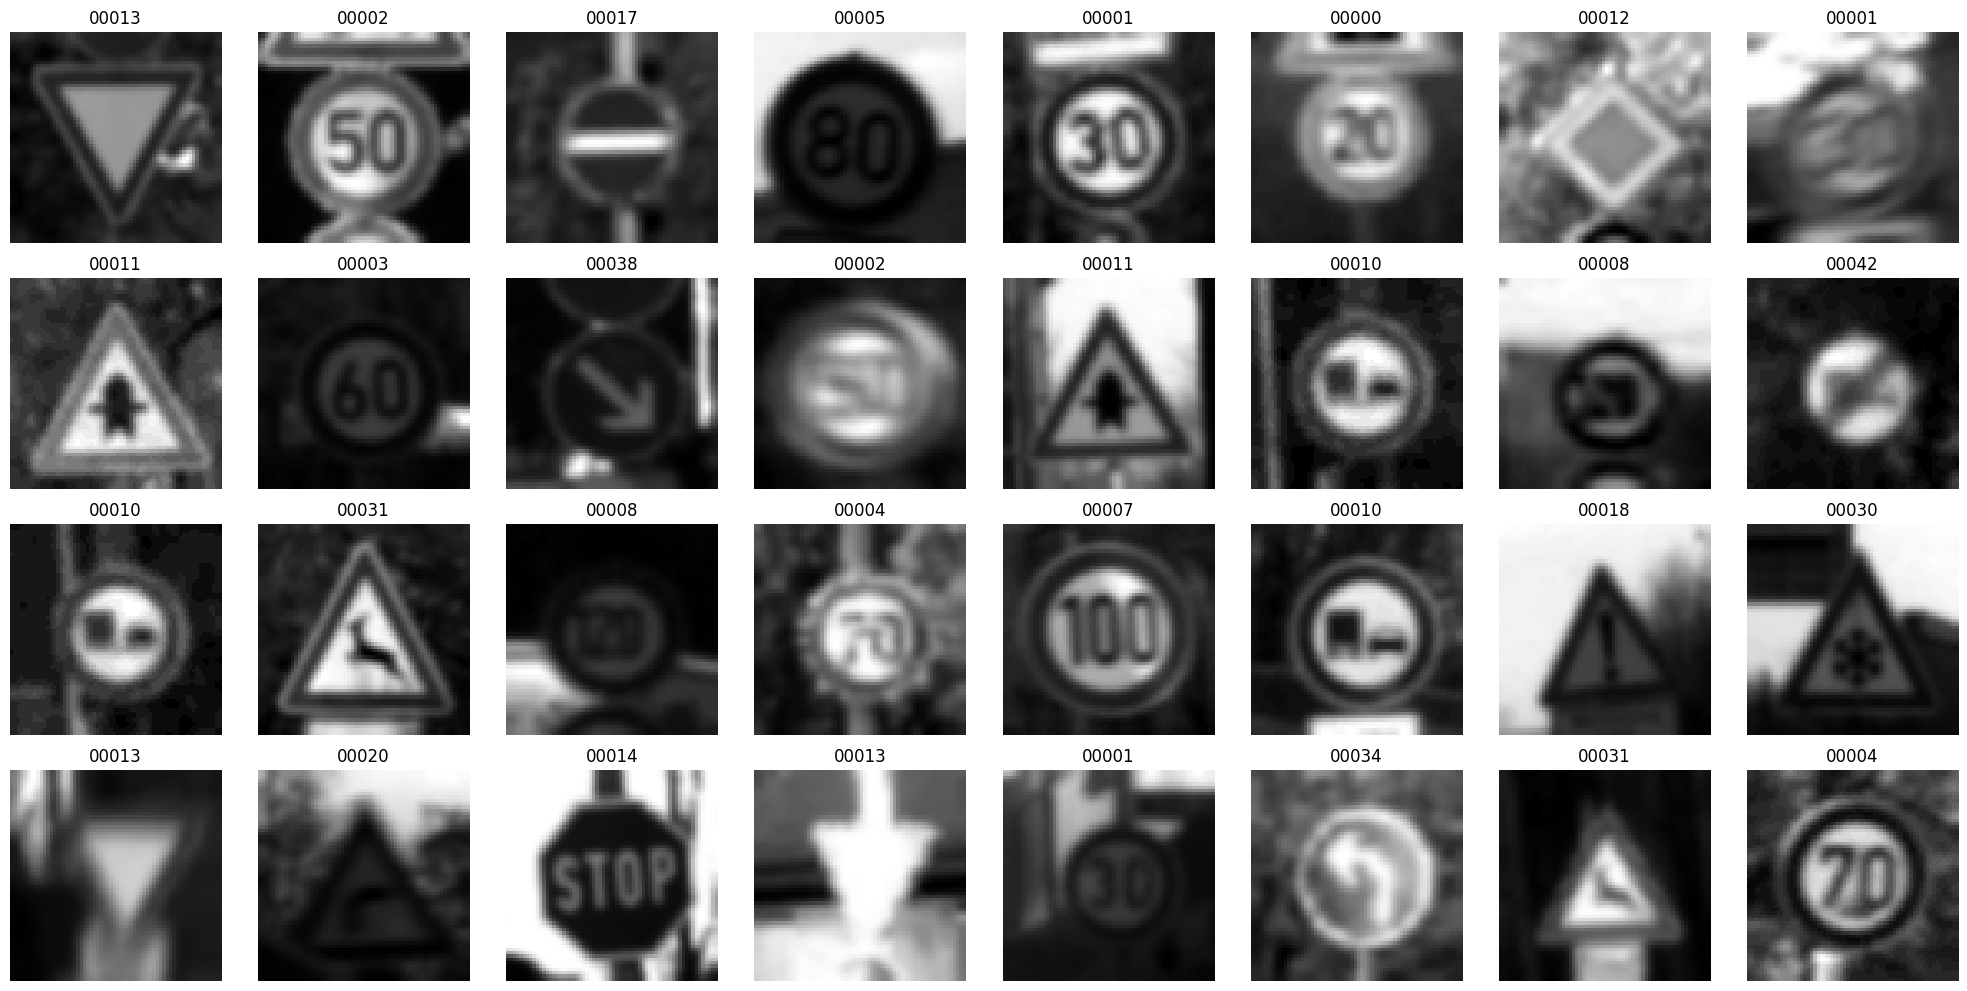

In [ ]:
# # Parâmetros do GaussianBlur
# m = 7  # Tamanho do kernel, ajuste conforme necessário
# sigma = 0  # Desvio padrão, ajuste conforme necessário
# blurred_images = []

def show_images(rows, cols, images, targets, classes):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    for idx, (img, target) in enumerate(zip(images, targets)):
        if idx >= rows * cols:
            break

        # Certifique-se de que a imagem está em formato numpy
        if torch.is_tensor(img):
            image = img.numpy()
        else:
            image = img

        image = np.transpose(image, (1, 2, 0))
        image = (image * 255).astype(np.uint8)

        # Converter RGB para Grayscale se necessário
        if image.shape[2] == 3:
            try:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            except Exception as e:
                print(f"Erro ao converter para grayscale: {e}")
                continue

        # Aplicar GaussianBlur para a GrayScale
        m = 5  # Tamanho do kernel
        sigma = 0  # Desvio padrão
        blurred_image = cv2.GaussianBlur(image, (m, m), sigma)

        # Display the image
        ax = axes.ravel()[idx]
        ax.set_title(classes[target])
        ax.imshow(blurred_image, cmap='gray')  # Ensure cmap is set to 'gray' for grayscale images
        ax.axis('off')
    fig.tight_layout()
    plt.show()

# Obter algumas imagens de treinamento para exibição
images, targets = next(iter(train_loader))
show_images(4, 8, images, targets, train_set.classes)

In [ ]:
# equalized_imgs_numpy = np.stack(equalized_imgs)
# equalized_imgs_tensor = torch.tensor(equalized_imgs_numpy)

# vcpi_util.show_images(5,10, equalized_imgs_tensor, train_targets, train_set.classes)

Aplicação do filtro 'medianBlur' - remoção de ruído (Fixed by Fernas)

In [ ]:
def show_images(rows, cols, images, targets, classes):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    for idx, img in enumerate(images):
        # Convert to numpy and handle tensor condition
        image = img.numpy() if torch.is_tensor(img) else img
        image = np.transpose(image, (1, 2, 0))
        image = (image * 255).astype(np.uint8)

        # Converter RGB para Grayscale
        if image.shape[2] == 3:
            try:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            except Exception as e:
                print(f"Error converting to grayscale: {e}")
                continue

        # Aplicar medianBlur para a GrayScale
        image = cv2.medianBlur(image, 3)

        # Display the image
        ax = axes.ravel()[idx]
        ax.set_title(classes[targets[idx]])
        ax.imshow(image, cmap='gray')  # Ensure cmap is set to 'gray' for grayscale images
        ax.axis('off')
    fig.tight_layout()
    plt.show()

show_images(8, 4, train_images, train_loader, train_loader.classes)


AttributeError: 'DataLoader' object has no attribute 'classes'

Transformar as imagens em formato binário (threshold)

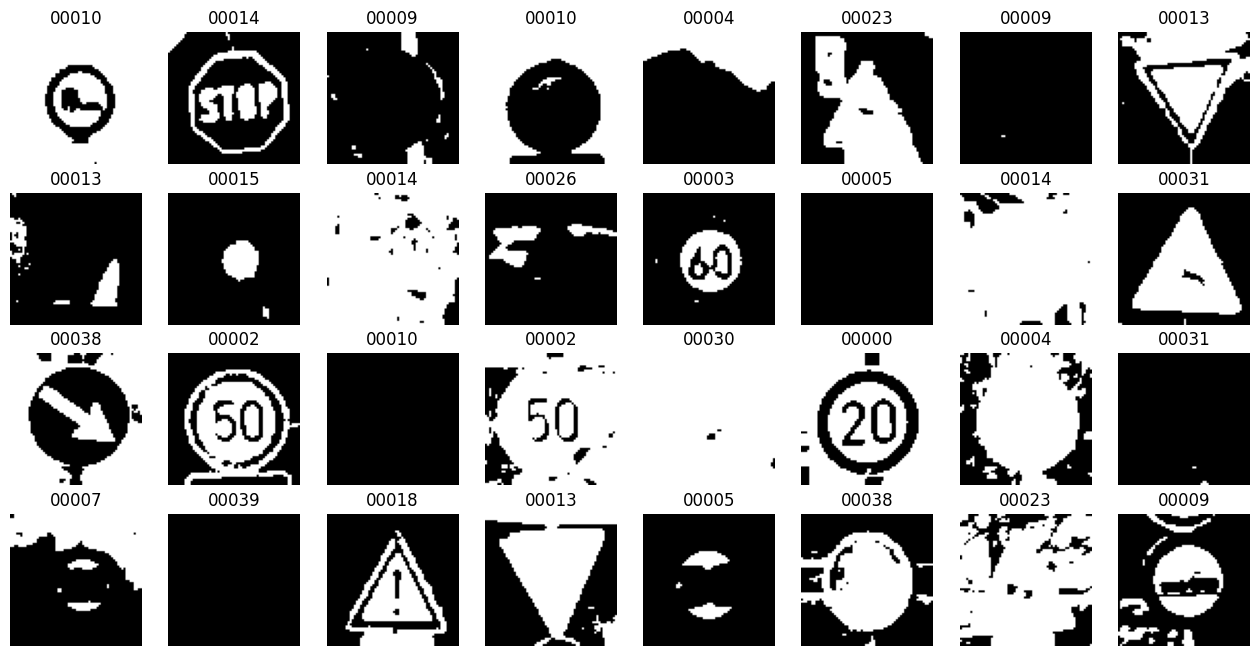

<Figure size 640x480 with 0 Axes>

In [ ]:
# Supondo que a transformação ThresholdTransform esteja definida corretamente como:
class ThresholdTransform:
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, img):
        img = v2.Grayscale()(img)
        img_bin = torch.where(img > self.threshold, torch.tensor(1.0), torch.tensor(0.0))
        return img_bin

threshold_transform = ThresholdTransform(threshold=0.35)

images_binarized = []
for image in train_images:
    image_binarized = threshold_transform(image)
    images_binarized.append(image_binarized)

# Converter a lista de imagens binarizadas para um tensor
images_binarized = torch.stack(images_binarized)

vcpi_util.show_images(4, 8, images_binarized, train_targets, train_set.classes)

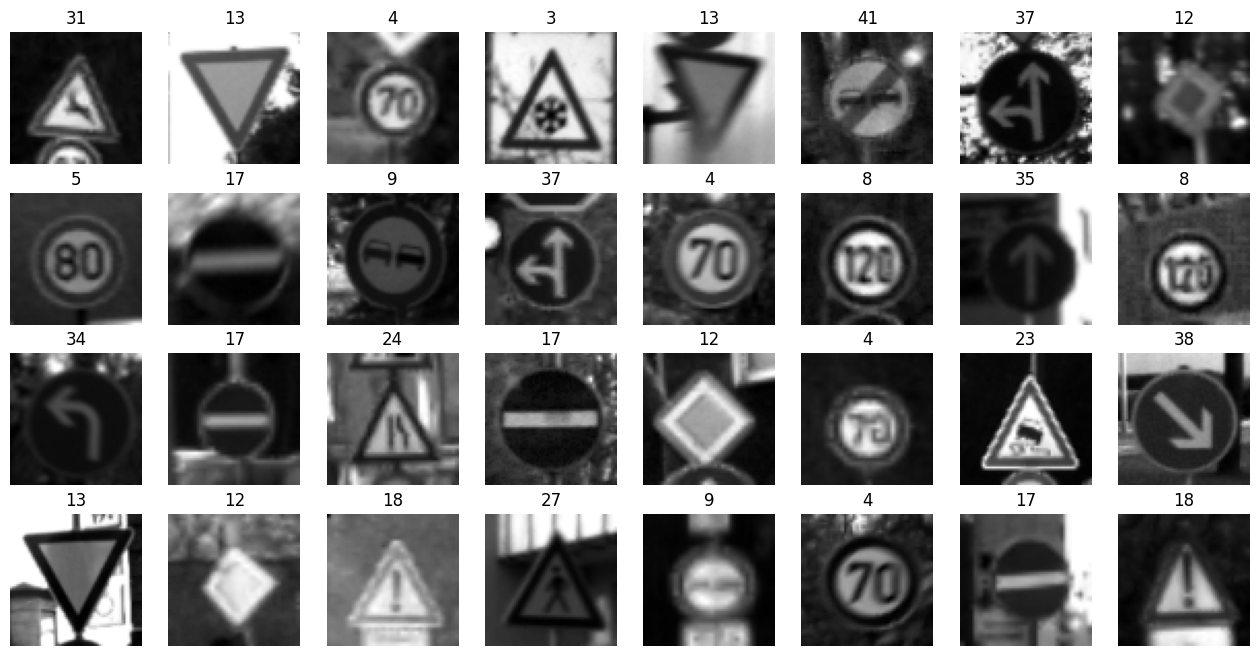

<Figure size 640x480 with 0 Axes>

In [ ]:
## testes de transformações, para não estragar o de cima

transform = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.RandomAdjustSharpness(0.5),
    # v2.RandomApply([v2.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2))], p=0.5),
    # v2.CenterCrop((CROP_HEIGHT, CROP_WIDTH)),  # Add this line for center cropping
    # v2.RandomCrop((CROP_HEIGHT, CROP_WIDTH)),  # Or use this line for random cropping
    v2.ToTensor(),
    v2.Grayscale()

])

train_set = torchvision.datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.MNIST(root=TEST_SET_PATH, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

images, targets = next(iter(train_loader))

new_class_names = ['0' if class_name == '00000' else class_name.replace('0', '') for class_name in train_set.classes]
train_set.classes = new_class_names

vcpi_util.show_images(4, 8, images, targets, train_set.classes)

# Auxiliar Functions

In [ ]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0

    for i, (images, targets) in enumerate(data_loader):

        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum
        # value of each row of the input tensor in the given dimension dim;
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


def train(model, data_loader, epochs, loss_fn, optimizer):

    # sets the model in training mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time()
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):

            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return(history)




def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(dataset.dataset.classes))

def prepare_callbacks(path):
    checkpointer = ModelCheckpoint(filepath= path,
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 10, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=5,
                                 mode='auto',
                                 min_lr=0.000000001,
                                 verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]


# Modelos

Este código prepara e organiza o conjunto das imagens para treinamento e validação, onde são aplicadas transformações de pré-processamento e técnicas de augmentação. São divididos os dados em conjuntos de treino e validação para um treino eficaz e avaliação do desempenho do modelo.

In [ ]:
# Definindo as transformações para normalizar as imagens, convertê-las para tensores e aplicar augmentação
transform_original = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização para ImageNet
])

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Aplica uma chance aleatória de flip horizontal
    transforms.RandomRotation(10),  # Aplica uma rotação aleatória até 10 graus
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização para ImageNet
])

# Usando a lista de índices filtrados para criar o target_transform
original_dataset = datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform_original)
augmented_dataset = datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform)

combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Dividindo o conjunto de dados combinado em treino e validação
train_size = int(0.8 * len(augmented_dataset))  # 80% para treinamento
val_size = len(augmented_dataset) - train_size  # 20% para validação
train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

# Criando os DataLoaders para treinamento e validação
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Uma maneira para também fazer data augumentation é inverter as imagens horizontalmente ou rodar aleatóriamente. Também dá para normalizar as imagens

In [ ]:
# For the test set
train_images, train_targets = next(iter(train_loader))
print("Train Set:")
print("Batch shape:", train_images.shape)
img_np = train_images.numpy()
img_np = img_np / 2.64  # Isso assume que seus valores originais variam entre -2.117904 e 2.64
img_np = np.clip(img_np, 0, 1)
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Each image varies between", np.min(img_np), "and", np.max(img_np))
# Putting color channel last so that the image can be displayed
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Shape after channel transpose:", img_np.shape)
# print("Test set samples:", len(train_loader.dataset))
print("Test set batches:", len(train_loader))

Train Set:
Batch shape: torch.Size([32, 3, 64, 64])
Each image varies between 0.0 and 1.0
Shape after channel transpose: (32, 64, 3, 64)
Test set samples: 31423
Test set batches: 982


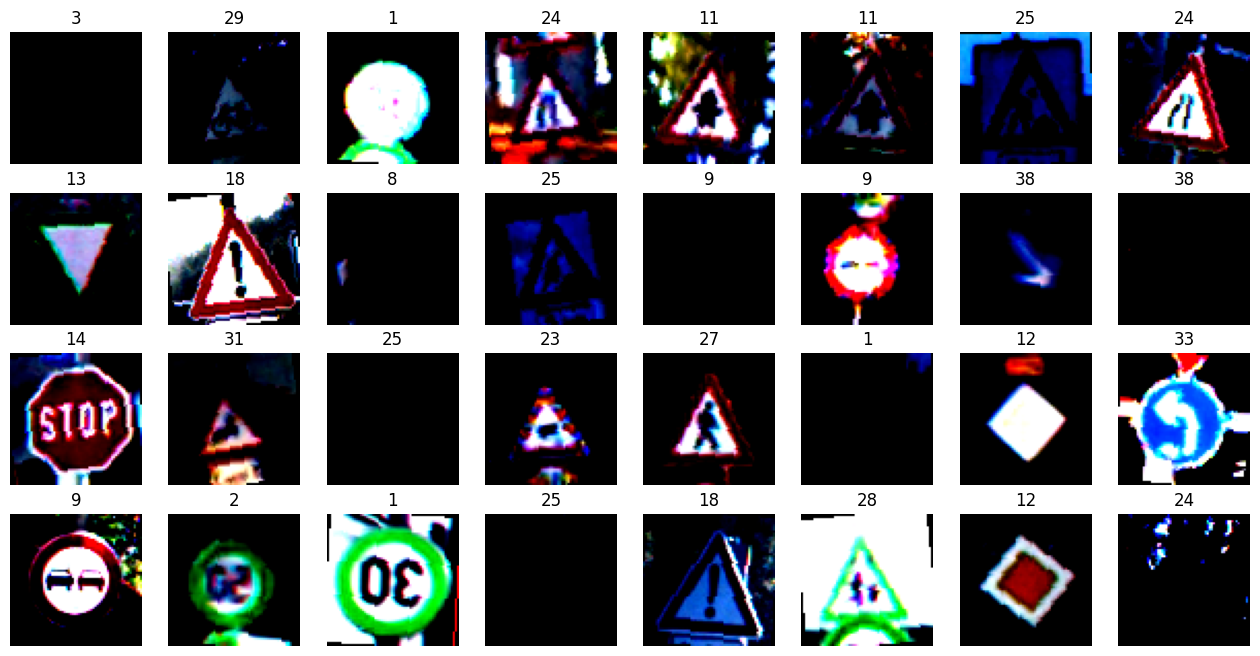

<Figure size 640x480 with 0 Axes>

In [ ]:

# Obter algumas imagens de treinamento para exibição
train_images, train_targets = next(iter(train_loader))
#train_images = np.clip(train_images.numpy(), 0, 1)
vcpi_util.show_images(4,8,train_images, train_targets, train_set.classes)

## CNN

In [ ]:

def model_I(classCount, imgSize, channels):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(imgSize, imgSize, channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer added for regularization
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(classCount, activation='softmax'))

    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model_I = model_I(43, 32, 3)

print(model_I.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_9 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 15, 15, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 13, 13, 64)       

In [ ]:
file_pathV1 = 'V1'
callbacksV1 = prepare_callbacks(file_pathV1)

historyI = model_I.fit(train_loader, epochs=20, validation_data=val_loader, callbacks=callbacksV1)

ValueError: Failed to find data adapter that can handle input: <class 'torch.utils.data.dataloader.DataLoader'>, <class 'NoneType'>

In [ ]:
show_history(historyI)

In [ ]:
vcpi_util.show_accuracies(train_acc, eval_acc, ['Conv 1', 'Conv 2'])

In [ ]:
def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))

build_confusion_matrix(model_Conv_II, test_loader)

Fazer com mais filtros

## vgg16

De acordo com a documentação oficial do PyTorch, o VGG16 requer um tamanho mínimo de entrada de 32x32 pixels. Embora o VGG16 possa aceitar imagens maiores, como 224x224 pixels, que é o tamanho de entrada padrão para muitos modelos de aprendizado profundo, ele também pode funcionar com imagens menores, como 64x64 pixels. No entanto, o desempenho do modelo pode ser afetado pela diminuição do tamanho da imagem, pois o modelo pode perder informações visuais importantes.

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# Remover a última camada de classificação para ajustar ao seu número de classes
NUM_FEATURES = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]  # Remover a última camada
features.extend([nn.Linear(NUM_FEATURES, NUM_CLASSES)])  # Adicionar a nova camada
vgg16.classifier = nn.Sequential(*features)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg16.to(device)
print(f'device: {device}')

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

c:\Users\ferna\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ferna\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device: cuda:0


In [ ]:
def train_vgg16_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'accuracy': [], 'loss': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['accuracy'].append(accuracy)
        history['loss'].append(running_loss / len(train_loader))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}')

        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        accuracy_val = 100 * correct_val / total_val
        print(f'Validation Accuracy: {accuracy_val}')

    return history

In [ ]:
history = train_vgg16_model(vgg16, criterion, optimizer, train_loader, val_loader)

final_accuracy = evaluate(vgg16, val_loader)
print(f'Final Validation Accuracy: {final_accuracy}%')

Epoch 1, Loss: 0.7002421252459865, Accuracy: 78.45187617559856
Validation Accuracy: 95.62611578678909
Epoch 2, Loss: 0.08133800006622582, Accuracy: 97.25507699174291
Validation Accuracy: 98.29125223157358
Epoch 3, Loss: 0.04350058902053616, Accuracy: 98.53349061115185
Validation Accuracy: 98.76307064524356
Epoch 4, Loss: 0.0273620127977577, Accuracy: 99.1455988778015
Validation Accuracy: 98.73756694720734
Epoch 5, Loss: 0.018577064265919107, Accuracy: 99.41977237223834
Validation Accuracy: 99.23488905891354
Epoch 6, Loss: 0.015830065599388682, Accuracy: 99.45802913890394
Validation Accuracy: 98.58454475899005
Epoch 7, Loss: 0.011694710707458596, Accuracy: 99.61424426945516
Validation Accuracy: 99.20938536087732
Epoch 8, Loss: 0.008891419839058752, Accuracy: 99.71626231389678
Validation Accuracy: 99.47717419025759
Epoch 9, Loss: 0.008325642157207061, Accuracy: 99.76089520833997
Validation Accuracy: 99.6557000765111
Epoch 10, Loss: 0.005269053300938077, Accuracy: 99.83422067778238
Valida

## ResNet

In [ ]:
model = models.resnet50(pretrained=True)

NUM_FEATURES = model.fc.in_features
model.fc = nn.Linear(NUM_FEATURES, NUM_CLASSES)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def train_resnet_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'accuracy': [], 'loss': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['accuracy'].append(accuracy)
        history['loss'].append(running_loss / len(train_loader))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}')

        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        accuracy_val = 100 * correct_val / total_val
        print(f'Validation Accuracy: {accuracy_val}')

    return history

c:\Users\ferna\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ferna/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [07:45<00:00, 220kB/s] 


In [ ]:
history = train_resnet_model(model, criterion, optimizer, train_loader, val_loader)

final_accuracy = evaluate(model, val_loader)
print(f'Final Validation Accuracy: {final_accuracy}%')

Epoch 1, Loss: 0.5951395030138174, Accuracy: 83.53365001434629
Validation Accuracy: 98.02346340219331
Epoch 2, Loss: 0.13466906654660943, Accuracy: 95.67379730289795
Validation Accuracy: 98.1764855904106
Epoch 3, Loss: 0.050011965613053905, Accuracy: 98.37408741671183
Validation Accuracy: 98.90334098444275
Epoch 4, Loss: 0.033968185710446706, Accuracy: 98.91605827780789
Validation Accuracy: 98.76307064524356
Epoch 5, Loss: 0.021308960796102488, Accuracy: 99.32413045557433
Validation Accuracy: 98.89058913542463
Epoch 6, Loss: 0.01544011271793005, Accuracy: 99.48672171390315
Validation Accuracy: 99.01810762560571
Epoch 7, Loss: 0.011817440955167046, Accuracy: 99.62062039723276
Validation Accuracy: 99.57918898240244
Epoch 8, Loss: 0.015959543500683567, Accuracy: 99.46121720279274
Validation Accuracy: 99.38791124713083
Epoch 9, Loss: 0.009461120131570626, Accuracy: 99.71626231389678
Validation Accuracy: 99.43891864320327
Epoch 10, Loss: 0.0076374794312859, Accuracy: 99.78002359167277
Valid

## AlexNet